安装所需要的dependencies

In [1]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import re
import os

import dashscope
from dashscope import TextEmbedding
from dashvector import Client, Doc

import json

from sklearn.metrics.pairwise import cosine_similarity
from dashscope import Generation

import fitz

from pysbd import Segmenter
from tqdm import tqdm
from dotenv import load_dotenv
load_dotenv()

api = [os.getenv('MODEL_API'), os.getenv('VECTOR_API'), os.getenv('ENDPOINT')]


处理pdf文件

In [2]:
import fitz

from pysbd import Segmenter

segmenter = Segmenter()

def read_pdfs_to_list(folder_path):
    pdf_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            with fitz.open(file_path) as doc:
                full_text = ""
                for page in doc:
                    full_text += page.get_text()
                
                full_text = re.sub(r"\n", " ", full_text)
                full_text = re.sub(r"\xa0", " ", full_text)
                full_text = re.sub(r"- ", "", full_text)
                pdf_texts.append(segmenter.segment(full_text.lower()))
    return pdf_texts

folder_path = 'D:\\RexZhann\\nlp\\PsyExtraction\\papers'


pdf_texts = read_pdfs_to_list(folder_path)


KeyboardInterrupt: 

处理txt文件

In [110]:
segmenter = Segmenter()

def read_txts_to_list(folder_path):
    txt_texts = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                full_text = file.read()
                
                # 清理文本，替换换行符和非打印字符
                full_text = re.sub(r"\xa0", " ", full_text)
                
                # 去除可能存在的其他不需要的字符或格式
                full_text = re.sub(r"-\n ", "", full_text)
                full_text = re.sub(r"  ", "", full_text)
                full_text = re.sub(r" - ", "-", full_text)
                # 使用pysbd进行句子分割
                txt_texts.append(full_text.split('\n\n'))
                # txt_texts.append(segmenter.segment(full_text.lower()))
    return txt_texts


txt_texts = read_txts_to_list(folder_path)


In [111]:
txt_texts = [[re.sub(r"\n", " ", para.lower()) for para in txt_text] for txt_text in txt_texts]
txt_texts

[['f00-f09 organic, including symptomatic, mental disorders',
  'overview of this block',
  "f00 dementia in alzheimer's disease  f00.0 dementia in alzheimer's disease with early onset  f00.1 dementia in alzheimer's disease with late onset  f00.2 dementia in alzheimer's disease, atypical or mixed type  f00.9 dementia in alzheimer's disease, unspecified",
  'f01 vascular dementia  f01.0 vascular dementia of acute onset  f01.1 multi-infarct dementia  f01.2 subcortical vascular dementia  f01.3 mixed cortical and subcortical vascular dementia  f01.8 other vascular dementia  f01.9 vascular dementia, unspecified',
  "f02 dementia in other diseases classified elsewhere  f02.0 dementia in pick's disease  f02.1 dementia in creutzfeldt-jakob disease  f02.2 dementia in huntington's disease  f02.3 dementia in parkinson's disease  f02.4 dementia in human immunodeficiency virus [hiv] disease  f02.8 dementia in other specified diseases classified elsewhere",
  'f03 unspecified dementia',
  'a fifth c

输入关键词

In [113]:
keyword = "depressive episode"

dep_key = 'diagnostic guidelines'

In [114]:
def tokenizer_batch(articles, keyword, dep_key, batchsize=5):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of retrieving information from scientific literature. 
            You are given a batch of paragraphs from scientific papers, and you are asked to seek for information about the topic of {keyword}, 
            and the paragraphs are likely to contain the {dep_key} of {keyword}.
            # OBJECTIVE #
            find out the {dep_key} of {keyword}{' '.join(batch)}
            # STYLE #
            output only the result of retrieval, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible. Be extra careful when a paragraph is likely to contain the {dep_key} of {keyword}
            # RESPONSE #
            do not output anything other than the result of retrieval, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase. If the batch seems not have the {dep_key} of {keyword}, skip the batch.
            '''
            
            rsp = Generation.call(model='qwen-max', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


筛选出相关段落（窗口大小可以自行调整）

In [117]:
def find_related_sent(keyword, sentences):
    related_sent = []
    for sent_per_text in sentences:
        for i, sent in enumerate(sent_per_text):
            if keyword.lower() in sent:
                for j in range(np.max([0, i - 10]), np.min([i + 10, len(sent_per_text)])):
                    if sent_per_text[j] not in related_sent:
                        if len(sent_per_text[j]) > 1200:
                            related_sent.append(sent_per_text[j][:500])
                            related_sent.append(sent_per_text[j][501: ])
                        else:
                            related_sent.append(sent_per_text[j])
    articles = list(set(related_sent))
    articles = [phrase for phrase in articles if len(phrase) > 4]
    return articles


articles = find_related_sent(keyword, txt_texts)
len(articles)

337

In [118]:
# 调试信息

max([len(text) for text in articles])

1194

In [119]:
aticles = list(set(articles))
articles = [phrase for phrase in articles if len(phrase) > 4]

len(articles)

337

根据文本长度来决定要不要剪短

In [71]:
## articles = articles[30:480]

In [72]:
dashscope.api_key=api[0]

def generate_embeddings(text):
    rsp = TextEmbedding.call(model=TextEmbedding.Models.text_embedding_v2,
                             input=text)
    embeddings = [record['embedding'] for record in rsp.output['embeddings']]
    return embeddings if isinstance(text, list) else embeddings[0]


In [73]:
def para_sum(articles):

    res = []
    for i, para in enumerate(articles):

        prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
                # CONTEXT #
                You are an professional and seasoned expert with 20 years experience of summarizing text based on the deep connections 
                within context and dependency of the text, including recognizing any named entities, possible phrases and chunks of 
                nouns especially prepositional phrases with objects of preposition. You are also good at recognizing the logical relation 
                between the phrases in one context. The purpose of summarization is to explore the {dep_key} of {keyword} based on the given paragraphs.
                # OBJECTIVE #
                Summarize this paragraph: {para}
                # STYLE #
                output only the summarization result, all the words chosen must be originally from the given paragraph. Skip any paragraph with no complete sentence structure and use the original para as the output
                Be extra careful when a paragraph is likely to contain the {dep_key} of {keyword}
                # RESPONSE #
                do not output anything other than the resulted summary. Do not write any explanatory contents for the summarization. Output English only
                '''
        
        rsp = Generation.call(model='qwen-turbo', prompt=prompt)
        res.append(rsp.output.text.lower())
    
    return res

In [74]:
sum_art = para_sum(articles)

KeyboardInterrupt: 

In [34]:
sum_art

["summarization of f00-f09 paragraph: exploring diagnostic guidelines for dementia in alzheimer's disease, this text delves into the critical aspects of recognizing and assessing alzheimer's patients. it emphasizes the importance of understanding the cognitive decline, memory loss, and behavioral changes that characterize alzheimer's, aiming to provide healthcare professionals with essential tools for accurate diagnosis and management.",
 "organic mental disorders, both symptomatic, pertain to alzheimer's disease diagnostics.",
 "overview of this block discusses the diagnostic guidelines for dementia in alzheimer's disease.",
 "dementia in alzheimer's disease involves specific diagnostic guidelines.",
 "dementia in alzheimer's disease with early onset.",
 "dementia in alzheimer's disease with late onset",
 "dementia in alzheimer's disease, atypical or mixed type.",
 "dementia in alzheimer's disease, unspecified.",
 'vascular dementia',
 'vascular dementia of acute onset',
 'multi-infar

In [75]:
def tokenizer_batch(articles, keyword, dep_key, batchsize=5):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of tokenizing text based on the deep connection 
            within context and dependency of the text, including extracting out any named entities, possible phrases and chunks of 
            nouns especially prepositional phrases with objects of preposition. You are also good at recognizing the logical relation 
            between the phrases in one context. The purpose of tokenization is to explore the {dep_key} of {keyword} based on the given paragraphs.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{' '.join(batch)}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible. Be extra careful when a paragraph is likely to contain the {dep_key} of {keyword}
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase.
            '''
            
            rsp = Generation.call(model='qwen-max', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [120]:
res = tokenizer_batch(articles, keyword, dep_key) 

phrases_llm = [re.findall(r'"(.*?)"', phrase) for phrase in res]



  0%|          | 0/68 [00:00<?, ?it/s]

Debug: Processing batch 1/68 with 5 phrases


  7%|▋         | 5/68 [00:09<02:00,  1.91s/it]

Debug: Processing batch 2/68 with 5 phrases


 15%|█▍        | 10/68 [00:18<01:46,  1.84s/it]

Debug: Processing batch 3/68 with 5 phrases


 22%|██▏       | 15/68 [00:33<02:03,  2.34s/it]

Debug: Processing batch 4/68 with 5 phrases


 29%|██▉       | 20/68 [00:43<01:45,  2.20s/it]

Debug: Processing batch 5/68 with 5 phrases


 37%|███▋      | 25/68 [00:57<01:46,  2.47s/it]

Debug: Processing batch 6/68 with 5 phrases


 44%|████▍     | 30/68 [01:05<01:20,  2.12s/it]

Debug: Processing batch 7/68 with 5 phrases


 51%|█████▏    | 35/68 [01:06<00:49,  1.50s/it]

Debug: Processing batch 8/68 with 5 phrases


 59%|█████▉    | 40/68 [01:25<01:03,  2.28s/it]

Debug: Processing batch 9/68 with 5 phrases


 66%|██████▌   | 45/68 [01:32<00:46,  2.01s/it]

Debug: Processing batch 10/68 with 5 phrases


 74%|███████▎  | 50/68 [01:39<00:32,  1.79s/it]

Debug: Processing batch 11/68 with 5 phrases


 81%|████████  | 55/68 [01:49<00:24,  1.85s/it]

Debug: Processing batch 12/68 with 5 phrases


 88%|████████▊ | 60/68 [01:55<00:13,  1.64s/it]

Debug: Processing batch 13/68 with 5 phrases


 96%|█████████▌| 65/68 [02:09<00:06,  2.03s/it]

Debug: Processing batch 14/68 with 5 phrases


70it [02:15,  1.75s/it]                        

Debug: Processing batch 15/68 with 5 phrases


75it [02:21,  1.57s/it]

Debug: Processing batch 16/68 with 5 phrases


80it [02:36,  2.00s/it]

Debug: Processing batch 17/68 with 5 phrases


85it [02:50,  2.24s/it]

Debug: Processing batch 18/68 with 5 phrases


90it [02:55,  1.87s/it]

Debug: Processing batch 19/68 with 5 phrases


95it [02:59,  1.58s/it]

Debug: Processing batch 20/68 with 5 phrases


100it [03:05,  1.47s/it]

Debug: Processing batch 21/68 with 5 phrases


105it [03:19,  1.83s/it]

Debug: Processing batch 22/68 with 5 phrases


110it [03:29,  1.91s/it]

Debug: Processing batch 23/68 with 5 phrases


115it [03:39,  1.91s/it]

Debug: Processing batch 24/68 with 5 phrases


120it [03:46,  1.80s/it]

Debug: Processing batch 25/68 with 5 phrases


125it [03:55,  1.81s/it]

Debug: Processing batch 26/68 with 5 phrases


130it [03:59,  1.46s/it]

Debug: Processing batch 27/68 with 5 phrases


135it [04:13,  1.88s/it]

Debug: Processing batch 28/68 with 5 phrases


140it [04:22,  1.83s/it]

Debug: Processing batch 29/68 with 5 phrases


145it [04:24,  1.42s/it]

Debug: Processing batch 30/68 with 5 phrases


150it [04:29,  1.30s/it]

Debug: Processing batch 31/68 with 5 phrases


155it [04:43,  1.72s/it]

Debug: Processing batch 32/68 with 5 phrases


160it [04:51,  1.69s/it]

Debug: Processing batch 33/68 with 5 phrases


165it [05:04,  1.99s/it]

Debug: Processing batch 34/68 with 5 phrases


170it [05:06,  1.50s/it]

Debug: Processing batch 35/68 with 5 phrases


175it [05:21,  1.95s/it]

Debug: Processing batch 36/68 with 5 phrases


180it [05:29,  1.88s/it]

Debug: Processing batch 37/68 with 5 phrases


185it [05:45,  2.26s/it]

Debug: Processing batch 38/68 with 5 phrases


190it [05:52,  2.02s/it]

Debug: Processing batch 39/68 with 5 phrases


195it [06:00,  1.90s/it]

Debug: Processing batch 40/68 with 5 phrases


200it [06:06,  1.69s/it]

Debug: Processing batch 41/68 with 5 phrases


205it [06:22,  2.12s/it]

Debug: Processing batch 42/68 with 5 phrases


210it [06:34,  2.18s/it]

Debug: Processing batch 43/68 with 5 phrases


215it [06:39,  1.85s/it]

Debug: Processing batch 44/68 with 5 phrases


220it [06:46,  1.69s/it]

Debug: Processing batch 45/68 with 5 phrases


225it [06:59,  1.96s/it]

Debug: Processing batch 46/68 with 5 phrases


230it [07:15,  2.36s/it]

Debug: Processing batch 47/68 with 5 phrases


235it [07:23,  2.12s/it]

Debug: Processing batch 48/68 with 5 phrases


240it [07:37,  2.30s/it]

Debug: Processing batch 49/68 with 5 phrases


245it [07:41,  1.86s/it]

Debug: Processing batch 50/68 with 5 phrases


250it [07:50,  1.85s/it]

Debug: Processing batch 51/68 with 5 phrases


255it [07:55,  1.60s/it]

Debug: Processing batch 52/68 with 5 phrases


260it [08:00,  1.44s/it]

Debug: Processing batch 53/68 with 5 phrases


265it [08:03,  1.18s/it]

Debug: Processing batch 54/68 with 5 phrases


270it [08:27,  2.25s/it]

Debug: Processing batch 55/68 with 5 phrases


275it [08:41,  2.41s/it]

Debug: Processing batch 56/68 with 5 phrases


280it [08:48,  2.11s/it]

Debug: Processing batch 57/68 with 5 phrases


285it [09:03,  2.37s/it]

Debug: Processing batch 58/68 with 5 phrases


290it [09:15,  2.40s/it]

Debug: Processing batch 59/68 with 5 phrases


295it [09:25,  2.25s/it]

Debug: Processing batch 60/68 with 5 phrases


300it [09:36,  2.23s/it]

Debug: Processing batch 61/68 with 5 phrases


305it [09:48,  2.30s/it]

Debug: Processing batch 62/68 with 5 phrases


310it [09:53,  1.89s/it]

Debug: Processing batch 63/68 with 5 phrases


315it [10:00,  1.75s/it]

Debug: Processing batch 64/68 with 5 phrases


320it [10:06,  1.61s/it]

Debug: Processing batch 65/68 with 5 phrases


325it [10:35,  2.89s/it]

Debug: Processing batch 66/68 with 5 phrases


330it [10:44,  2.56s/it]

Debug: Processing batch 67/68 with 5 phrases


335it [10:53,  2.30s/it]

Debug: Processing batch 68/68 with 2 phrases


337it [10:55,  1.94s/it]


对输出进行处理

In [121]:
import nltk
from nltk.corpus import stopwords
from typing import List

# 获取英文停用词列表，包括连词和介词
stop_words = set(stopwords.words('english'))

p1 = r'^(f\d{2}-f\d{2})?'


phrases_llm = [[re.sub(p1, '', phrase.lower()) for phrase in phrases if len(phrase) <= 40 and len(re.sub(r'^(f\d{2}?)', '', phrase)) > 4 and '%' not in phrase and phrase not in stop_words] for phrases in phrases_llm]
phrases_llm = [phrases for phrases in phrases_llm if len(phrases) != 0]
phrases_llm

[['dissociative stupor',
  'agitation',
  'over activity',
  'flight reaction',
  'fugue',
  'autonomic signs',
  'panic anxiety',
  'tachycardia',
  'sweating',
  'flushing',
  'stressful stimulus',
  '2-3 days',
  'partial amnesia',
  'complete amnesia',
  'loss of interest',
  'pleasure',
  'activities',
  'emotional reactivity',
  'psychomotor retardation',
  'agitation',
  'marked loss of appetite',
  'weight loss',
  'loss of libido',
  'mixed categories',
  'anxiety',
  'depression',
  'delusional dysmorphophobia',
  'involutional paranoid state',
  'paranoia querulans',
  'recurrent episodes',
  'depressive reaction',
  'psychogenic depression',
  'reactive depression',
  'seasonal affective disorder',
  'endogenous depression',
  'major depression',
  'manic depressive psychosis',
  'depressed type',
  'psychotic depression',
  'vital depression'],
 ['schizophrenic patient',
  'post schizophrenic depression (f20.4)',
  'recurrent schizoaffective episodes',
  'manic or depressi

In [78]:
phrases_llmk = phrases_llm


phrase_res = []

ex_words = set([word for word in keyword.split() if word not in stop_words])

for sub in phrases_llmk:
    sub = [phrase for phrase in sub if not any(ex in phrase for ex in ex_words)]
    phrase_res.append(sub)

phrase_res


[['specific disorder',
  '(external to the individual)',
  'predominantly obsessional thoughts',
  'or ruminations',
  'or other'],
 ['major symptoms', 'free-floating', 'diagnostic guidelines'],
 ['disorder occur',
  'close association',
  'significant life changes',
  'particular environmental circumstances',
  'disease',
  '(f45.2)'],
 ['stressful life events', 'category f43.2', 'general f41.2'],
 ['consultations',
  'shift in the emphasis',
  'excludes',
  'f42 obsessive-compulsive disorder',
  'rheumatic fever'],
 ['affective', 'evoked', 'group', 'predominantly'],
 ['temporal lobe', 'unspecified', 'phobias', 'includes', 'phobia nos'],
 ['stability of the physical complaints',
  'possible physical',
  'schizophrenia (f20.-)',
  'panic disorder (f41.0)',
  'precedence over'],
 ['recurrent attacks',
  'epilepsy',
  'thyrotoxicosis',
  'phaechromocytoma',
  'unspecified'],
 ['well-defined situations', 'objects', 'panic disorder'],
 ['dominant symptoms',
  'depressive disorder',
  'dere

In [122]:
def dep_reco_batch(articles, phrases_llm, keyword, dep_key, batchsize=5):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    art_batch = list(batch_generator(articles, batchsize=5))

    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(phrases_llm):

            debug_info = f"Processing batch {idx + 1}/{len(art_batch) // batchsize + (len(art_batch) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Progress: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of recognizing the dependency relation of phrases based on the deep connection 
            within context and dependency of the text, including recognizing any named entities, possible phrases and chunks of 
            nouns especially prepositional phrases with objects of preposition. You are also good at recognizing the logical relation 
            between the phrases in one context. The purpose of dependency recognition is to explore the {dep_key} of {keyword} based on the given paragraphs.
            # OBJECTIVE #
            the list phrases of the context are here: {batch}, and the entire context is here: {' '.join(art_batch[idx])}
            # STYLE #
            You have six choices for labels: 'sub' for the phrase '{keyword}', 'cat' for phrases in the similar categories with 'sub', 'par' for synonyms of 
            the phrase '{dep_key}', 'des' for descriptions for the 'sub' and 'par' in the same sentence, 'dob' for the objects induced by {keyword} in the 
            sentences, and 'oth' for others in the sentences. Output a list of labels corresponding to each phrase in the input list that best fits their dependency.
            # RESPONSE #
            do not output anything other than the resulted list, do not output any label that's not in the given six. Any phrases with 'disease' inside should be 
            labeled 'cat' or 'sub'. The label 'des' usually means the phrase represents the key symptoms occurs alongside with the diagnosis of '{keyword}'
            '''
            
            rsp = Generation.call(model='qwen-max', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [123]:
dep_llm = dep_reco_batch(articles, phrase_res, keyword, dep_key, batchsize=5)

  0%|          | 0/68 [00:00<?, ?it/s]

Progress: Processing batch 1/14 with 5 phrases


  7%|▋         | 5/68 [00:01<00:19,  3.21it/s]

Progress: Processing batch 2/14 with 3 phrases


 12%|█▏        | 8/68 [00:03<00:26,  2.23it/s]

Progress: Processing batch 3/14 with 6 phrases


 21%|██        | 14/68 [00:05<00:19,  2.75it/s]

Progress: Processing batch 4/14 with 3 phrases


 25%|██▌       | 17/68 [00:07<00:23,  2.22it/s]

Progress: Processing batch 5/14 with 5 phrases


 32%|███▏      | 22/68 [00:08<00:18,  2.55it/s]

Progress: Processing batch 6/14 with 4 phrases


 38%|███▊      | 26/68 [00:10<00:16,  2.52it/s]

Progress: Processing batch 7/14 with 5 phrases


 46%|████▌     | 31/68 [00:11<00:13,  2.83it/s]

Progress: Processing batch 8/14 with 5 phrases


 53%|█████▎    | 36/68 [00:13<00:10,  3.05it/s]

Progress: Processing batch 9/14 with 5 phrases


 60%|██████    | 41/68 [00:14<00:08,  3.01it/s]

Progress: Processing batch 10/14 with 3 phrases


 65%|██████▍   | 44/68 [00:15<00:08,  2.94it/s]

Progress: Processing batch 11/14 with 6 phrases


 74%|███████▎  | 50/68 [00:17<00:05,  3.24it/s]

Progress: Processing batch 12/14 with 5 phrases


 81%|████████  | 55/68 [00:19<00:04,  3.18it/s]

Progress: Processing batch 13/14 with 5 phrases


 88%|████████▊ | 60/68 [00:20<00:02,  3.22it/s]

Progress: Processing batch 14/14 with 2 phrases


 91%|█████████ | 62/68 [00:21<00:02,  2.98it/s]

Progress: Processing batch 15/14 with 1 phrases


 93%|█████████▎| 63/68 [00:22<00:01,  2.57it/s]

Progress: Processing batch 16/14 with 3 phrases


 97%|█████████▋| 66/68 [00:23<00:00,  2.58it/s]

Progress: Processing batch 17/14 with 5 phrases


71it [00:25,  2.87it/s]                        

Progress: Processing batch 18/14 with 11 phrases


82it [00:27,  3.42it/s]

Progress: Processing batch 19/14 with 9 phrases


91it [00:29,  3.68it/s]

Progress: Processing batch 20/14 with 7 phrases


98it [00:31,  3.68it/s]

Progress: Processing batch 21/14 with 6 phrases


104it [00:33,  3.71it/s]

Progress: Processing batch 22/14 with 10 phrases


114it [00:37,  3.28it/s]

Progress: Processing batch 23/14 with 8 phrases


122it [00:39,  3.46it/s]

Progress: Processing batch 24/14 with 16 phrases


138it [00:44,  3.35it/s]

Progress: Processing batch 25/14 with 2 phrases


140it [00:44,  3.20it/s]

Progress: Processing batch 26/14 with 9 phrases


149it [00:46,  3.57it/s]

Progress: Processing batch 27/14 with 13 phrases


162it [00:51,  3.08it/s]

Progress: Processing batch 28/14 with 3 phrases


165it [00:53,  3.11it/s]


In [124]:
dep_llm[-9]

"['oth', 'cat', 'cat', 'cat', 'par', 'cat', 'oth']"

In [125]:

dep_llm = [phrase.replace("'", '"') for phrase in dep_llm]
dep = [json.loads(phrase) for phrase in dep_llm]

In [126]:
dep[-9][1]

'cat'

In [127]:
desc_phrases = [[phrase for phrase, label in zip(sublist_a, sublist_b) if label in ['dob', 'des', 'oth']] for sublist_a, sublist_b in zip(phrase_res, dep)]

desc_phrases

[['(external to the individual)',
  'predominantly obsessional thoughts',
  'or ruminations',
  'or other'],
 ['free-floating'],
 ['disorder occur',
  'significant life changes',
  'particular environmental circumstances',
  '(f45.2)'],
 ['stressful life events', 'general f41.2'],
 ['consultations', 'excludes', 'rheumatic fever'],
 ['affective', 'evoked', 'group', 'predominantly'],
 ['temporal lobe', 'unspecified', 'includes'],
 ['stability of the physical complaints',
  'possible physical',
  'precedence over'],
 ['recurrent attacks'],
 ['well-defined situations', 'objects'],
 ['derealization', 'obsessional symptoms', 'elements'],
 ['combination', 'consequence', 'organic', 'excludes:', 'unspecified (f41.-)'],
 ['phobic states nos',
  'depersonalization',
  'clearly indicate',
  'separate presence'],
 ['dominant symptoms', 'person to person'],
 ['prominent or delusional disorder'],
 ['diagnosis', 'varying degrees'],
 ['acute onset', 'hyperactive behaviour', 'child', 'school age'],
 ['e

In [128]:
desc_phrases = [phrases for phrases in desc_phrases if len(phrases) != 0]

desc_ph = []

for phrases in desc_phrases:
    phr = [phrase for phrase in phrases if not any(ex in phrase for ex in ex_words)]
    desc_ph.append(phr)

desc_ph = [phrases for phrases in desc_ph if len(phrases) != 0]


In [129]:
desc_ph


[['(external to the individual)',
  'predominantly obsessional thoughts',
  'or ruminations',
  'or other'],
 ['free-floating'],
 ['disorder occur',
  'significant life changes',
  'particular environmental circumstances',
  '(f45.2)'],
 ['stressful life events', 'general f41.2'],
 ['consultations', 'excludes', 'rheumatic fever'],
 ['affective', 'evoked', 'group', 'predominantly'],
 ['temporal lobe', 'unspecified', 'includes'],
 ['stability of the physical complaints',
  'possible physical',
  'precedence over'],
 ['recurrent attacks'],
 ['well-defined situations', 'objects'],
 ['derealization', 'obsessional symptoms', 'elements'],
 ['combination', 'consequence', 'organic', 'excludes:', 'unspecified (f41.-)'],
 ['phobic states nos',
  'depersonalization',
  'clearly indicate',
  'separate presence'],
 ['dominant symptoms', 'person to person'],
 ['prominent or delusional disorder'],
 ['diagnosis', 'varying degrees'],
 ['acute onset', 'hyperactive behaviour', 'child', 'school age'],
 ['e

In [130]:

client = Client(
  api_key=api[1],
  endpoint=api[2]
)


collection = client.get('sample1')
collection.delete(delete_all=True)  #清空collection
assert collection

In [131]:
def batch_generator(items, batchsize):
    for i in range(0, len(items), batchsize):
        yield items[i:i + batchsize]

def process_phrases(phrases_llm, batchsize=6):
    for batch in batch_generator(phrases_llm, batchsize):
        
        for sent in batch:
            embeddings = [generate_embeddings(phrase) for phrase in sent]

            
            docs = [Doc(id=str(len(phrase)), vector=embedding, fields={"title": phrase}) 
                    for phrase, embedding in zip(sent, embeddings)]
        
        rsp = collection.insert(docs)
        assert rsp
process_phrases(desc_ph, batchsize=5)


In [132]:
rsp = collection.query(generate_embeddings(keyword), output_fields=['title'], topk=15)



related_phrases = [doc.fields['title'] for doc in rsp.output]
related_phrases_embeddings = [doc.vector for doc in rsp.output]

for ex in ex_words:
    rsp1 = collection.query(generate_embeddings(ex), output_fields=['title'], topk=5)
    related_phrases += [doc.fields['title'] for doc in rsp1.output]

    related_phrases = list(set(related_phrases))

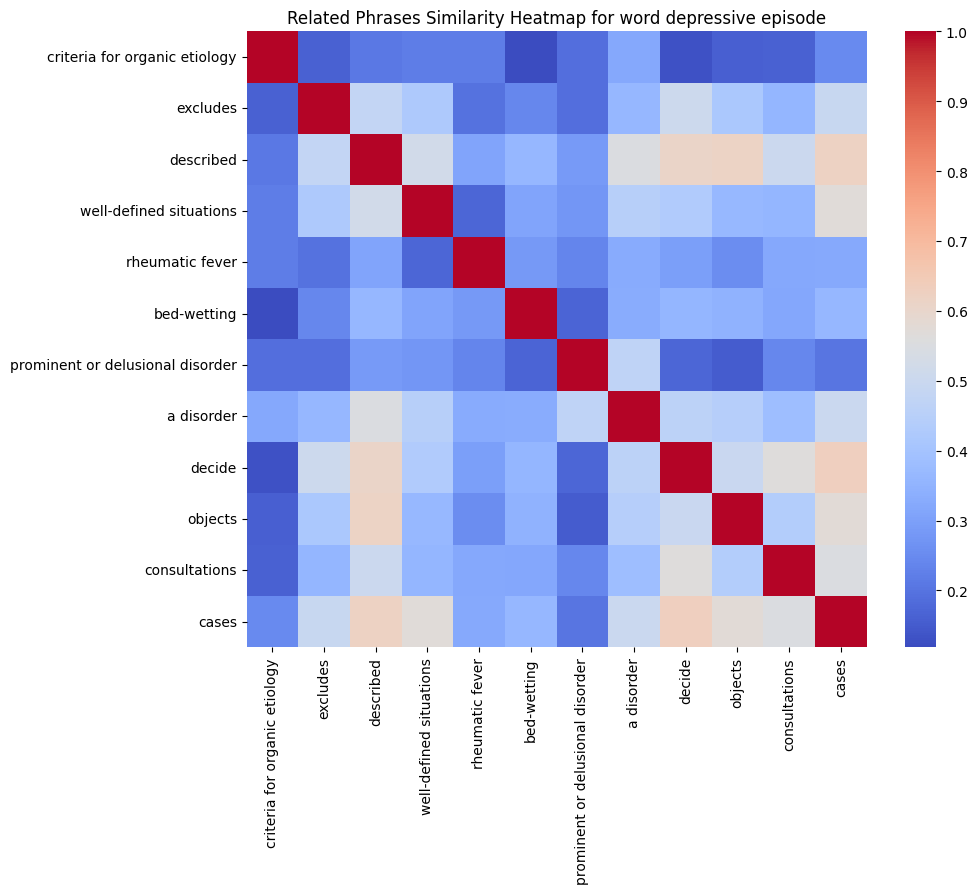

In [133]:
related_phrases_embeddings = [generate_embeddings(phrase) for phrase in related_phrases]

similarity_matrix = cosine_similarity(related_phrases_embeddings)

plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, xticklabels=related_phrases, yticklabels=related_phrases, cmap='coolwarm')
plt.title(f'Related Phrases Similarity Heatmap for word {keyword}')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [27]:
from sklearn.decomposition import PCA
import pandas as pd

embs = np.array(related_phrases_embeddings).T

In [42]:
pca = PCA(n_components=2)
pca.fit(embs)
tr_emb = pca.transform(embs)
exp = pca.explained_variance_ratio_
loadings = pca.components_

tr_df = pd.DataFrame(tr_emb, columns=['p1', 'p2'])
ld_df = pd.DataFrame(loadings, columns=[f"Dim{i+1}" for i in range(embs.shape[1])])

In [43]:
print(ld_df)

       Dim1      Dim2      Dim3      Dim4      Dim5      Dim6      Dim7  \
0  0.259386  0.318711  0.235674  0.338526  0.292552  0.352762  0.299563   
1  0.554408 -0.008147 -0.295545  0.149733 -0.235543 -0.006456  0.501241   

       Dim8      Dim9     Dim10     Dim11     Dim12  
0  0.239637  0.248924  0.212689  0.317934  0.309074  
1 -0.076659 -0.345392 -0.373843  0.040131 -0.097429  


In [91]:
def pca_features(final_phrases, final_emb):
    embs = np.array([ph for ph in final_emb]).T
    pca = PCA(n_components=2)
    pca.fit(embs)
    tr_emb = pca.transform(embs)
    exp = pca.explained_variance_ratio_
    loadings = pca.components_
    print(loadings)
    # 计算加权载荷绝对值
    weighted_loadings = loadings * np.sqrt(exp.reshape(-1, 1))
    
    # 计算每个特征的综合得分
    feature_scores = np.sum(np.abs(weighted_loadings), axis=1)
    
    # 根据综合得分对特征进行排序
    sorted_indices = np.argsort(loadings[0])[::-1]  # 降序排序
    sorted_features = [final_phrases[i] for i in sorted_indices]
    print(feature_scores)
    # 选择前N个最重要的特征
    N = 5  # 例如选择前5个
    ess_features = sorted_features[:N]

    tr_df = pd.DataFrame(tr_emb, columns=['p1', 'p2'])
    ld_df = pd.DataFrame(loadings, columns=[f"Dim {i+1}" for i in range(embs.shape[1])])

    return exp, tr_df, ld_df, ess_features

In [92]:
pca_features(related_phrases, related_phrases_embeddings)

[[ 0.28937911  0.27039509  0.29305664  0.28343165  0.27175178  0.27482179
   0.26033586  0.29864204  0.32709281  0.28591457  0.23646848  0.23629577
   0.26476928]
 [-0.29272862  0.46006165 -0.20441884  0.09863953  0.48750911 -0.19217984
   0.36656918 -0.24476728  0.0657401  -0.36423197 -0.1311264  -0.11741331
   0.11953031]]
[2.43943954 1.02771376]


(array([0.46112817, 0.10678892]),
             p1        p2
 0    -0.040478 -0.014284
 1     0.152229 -0.088073
 2     0.076989 -0.017076
 3     0.009909  0.013802
 4     0.003550  0.010155
 ...        ...       ...
 1531  0.067637 -0.027064
 1532  0.078668 -0.001866
 1533 -0.053422 -0.051078
 1534 -0.016519  0.000040
 1535  0.029084 -0.000066
 
 [1536 rows x 2 columns],
       Dim 1     Dim 2     Dim 3     Dim 4     Dim 5     Dim 6     Dim 7  \
 0  0.289379  0.270395  0.293057  0.283432  0.271752  0.274822  0.260336   
 1 -0.292729  0.460062 -0.204419  0.098640  0.487509 -0.192180  0.366569   
 
       Dim 8     Dim 9    Dim 10    Dim 11    Dim 12    Dim 13  
 0  0.298642  0.327093  0.285915  0.236468  0.236296  0.264769  
 1 -0.244767  0.065740 -0.364232 -0.131126 -0.117413  0.119530  ,
 ['affective', 'child', 'predominantly', 'conduct', 'elements'])

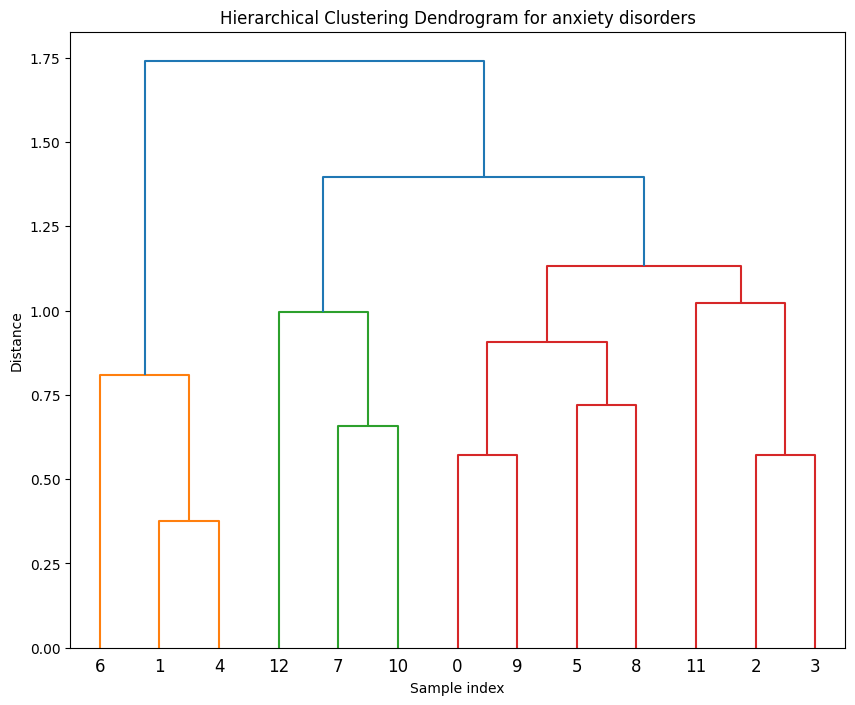

In [93]:
from scipy.cluster.hierarchy import dendrogram, linkage

# 层次聚类
Z = linkage(similarity_matrix, 'ward')

# 绘制层次聚类树状图
plt.figure(figsize=(10, 8))
dendrogram(Z)
plt.title(f'Hierarchical Clustering Dendrogram for {keyword}')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [94]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# 使用相似度矩阵进行层次聚类
Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

# 将短语分为k类
k = 6  # 假设我们要分为5类
clusters = fcluster(Z, k, criterion='maxclust')

def get_representative_phrases( clusters, k, related_phrases, related_phrases_embeddings, target_emb):
    rep_phrases = []
    rep_phrase_emb = []
    
    # 计算target_emb与所有短语嵌入的相似度
    target_similarity = np.dot(related_phrases_embeddings, target_emb)
    
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        
        # 如果当前聚类中没有元素，则跳过
        if not cluster_indices:
            continue
        
        # 计算target_emb与当前聚类中所有短语的相似度
        cluster_similarities = target_similarity[cluster_indices]
        
        # 找出与target_emb最相似的短语索引
        max_similarity_index = np.argmax(cluster_similarities)
        rep_index = cluster_indices[max_similarity_index]
        
        # 添加代表性短语和其嵌入向量
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
        
    return rep_phrases, rep_phrase_emb

final_phrases, final_emb = get_representative_phrases(clusters, k, related_phrases, related_phrases_embeddings, generate_embeddings(keyword))
print(f"Final {k} characteristics of {keyword}:")
for phrase in final_phrases:
    print(phrase)

Final 6 characteristics of anxiety disorders:
obsessional symptoms
child
acute onset
affective
predominant disturbance
essential descriptive features


In [98]:
def get_rep_phrases_average(similarity_matrix, related_phrases, related_phrases_embeddings, k=6):
    # 使用相似度矩阵进行层次聚类
    Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

    clusters = fcluster(Z, k, criterion='maxclust')
    rep_phrases = []
    rep_phrase_emb = []

    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        cluster_similarity = similarity_matrix[cluster_indices][:, cluster_indices]
        centroid_index = np.argmax(np.sum(cluster_similarity, axis=0))
        rep_index = cluster_indices[centroid_index]
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])

    return rep_phrases, rep_phrase_emb

In [100]:
get_rep_phrases_average(similarity_matrix, related_phrases, related_phrases_embeddings, k=6)

(['obsessional symptoms',
  'school age',
  'acute onset',
  'conduct',
  'predominant disturbance',
  'essential descriptive features'],
 [[-0.02527364635828941,
   -0.002034266045900891,
   0.004009160271721725,
   0.006412156568646126,
   -0.004502883828176934,
   0.017286574141203884,
   -0.024786172467105787,
   0.0011343142467926627,
   0.0012889934622643895,
   -0.010274449706485606,
   0.0750459805811917,
   -0.024298698575922165,
   0.003565434037439196,
   0.04052282962095661,
   -0.023473742760072955,
   -0.0048497402507498965,
   -0.01309929840924199,
   0.0063402854180228995,
   -0.004071656924437574,
   0.01229934125447912,
   -0.020486402760255363,
   -0.005380961798834615,
   0.022361302341730838,
   0.009799475145845152,
   0.000836673938233431,
   0.0008108940689881432,
   -0.018561505856607208,
   -0.010993161212717872,
   -0.009280752928303604,
   -0.022873774894000803,
   -0.00324045144331678,
   -0.06759637957746248,
   -0.01989893422472638,
   -0.0196739462749493

In [101]:
type(final_phrases)

list

In [102]:
embs = np.array([ph for ph in final_emb]).T
pca = PCA(n_components=2)
pca.fit(embs)
tr_emb = pca.transform(embs)
exp = pca.explained_variance_ratio_
loadings = pca.components_
argmax = np.argmax(np.abs(loadings), axis=1)
tr_df = pd.DataFrame(tr_emb, columns=['p1', 'p2'])
ld_df = pd.DataFrame(loadings, columns=[f"Dim{i+1}" for i in range(embs.shape[1])])
ess_features = [final_phrases[i] for i in list(argmax)]

In [103]:
print(ld_df)
print(ess_features)

       Dim1      Dim2      Dim3      Dim4      Dim5      Dim6
0  0.417206  0.394330  0.410578  0.471036  0.403230  0.342636
1 -0.309814 -0.257098 -0.257564  0.001601  0.089886  0.873782
['affective', 'essential descriptive features']


In [104]:
def translate_cn(final_phrases, model='qwen-max'):
    prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an seasoned expert with more than 20 years experience in translating English texts into Chinese given a list of entities.
            # OBJECTIVE #
            translate the following list into Chinese, in the same formatting.

            list of phrases: {final_phrases}

            # STYLE #
            output only the result of translation of each phrase, separated by quotation and comma.
            Set the temperature parameter to 0 to ensure a precise output
            # RESPONSE #
            do not output anything other than the result of translation
            '''
    rsp = Generation.call(model='qwen-turbo', prompt=prompt)
    return re.findall(r'"(.*?)"', rsp.output.text)

In [105]:
ts = translate_cn(final_phrases)


['大脑半球', '步态和括约肌', '缺血破坏灶', '深层白质', '轻度或中度智力迟滞', '代谢障碍']

In [106]:
from scipy.cluster.hierarchy import linkage, fcluster
import numpy as np

# 使用相似度矩阵进行层次聚类
Z = linkage(1 - similarity_matrix, 'ward')  # 使用1减去相似度矩阵作为距离矩阵

# 将短语分为k类
k = 6  # 假设我们要分为5类
clusters = fcluster(Z, k, criterion='maxclust')

def get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings):
    rep_phrases = []
    rep_phrase_emb = []
    for cluster_id in range(1, k + 1):
        cluster_indices = [i for i, c in enumerate(clusters) if c == cluster_id]
        cluster_similarity = similarity_matrix[cluster_indices][:, cluster_indices]
        centroid_index = np.argmax(np.sum(cluster_similarity, axis=0))
        rep_index = cluster_indices[centroid_index]
        rep_phrases.append(related_phrases[rep_index])
        rep_phrase_emb.append(related_phrases_embeddings[rep_index])
    return rep_phrases, rep_phrase_emb

# 获取代表性短语
final_phrases, final_emb = get_representative_phrases(similarity_matrix, clusters, k, related_phrases, related_phrases_embeddings)
print(f"Final {k} average characteristics of {keyword}:")


for phrase in final_phrases:
    print(phrase)


Final 6 average characteristics of anxiety disorders:
obsessional symptoms
school age
acute onset
conduct
predominant disturbance
essential descriptive features


In [107]:
def average_dot_product(vectors):
    n = len(vectors)
    dot_products = []

    for i in range(n):
        for j in range(i + 1, n):
            dot_product = np.dot(vectors[i], vectors[j])
            dot_products.append(dot_product)
    
    average_dot = np.mean(dot_products)
    return average_dot

ave_dot = average_dot_product(final_emb)
ave_cos = np.mean(cosine_similarity(final_emb))

print(f'average dot product is {ave_dot}')
print(f'average cosine similarity is {ave_cos}')

average dot product is 0.35189802177337365
average cosine similarity is 0.45991501814447805


In [108]:
def retriever_batch(articles, final_phrases, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an expert at retrieving a phrase from a text database given a list of the characteristics of that phrase.
            # OBJECTIVE #
            Pick exactly one phrase or word from the text database that best fits the list of characteristics.

            list of characteristics: {final_phrases}

            text database: {batch}

            # STYLE #
            output only the result of phrase retrieval. 
            The result could be a single word or a short phrase, but never a sentence. 
            The result must be from the text database.
            Set the temperature parameter to 0 to ensure a precise output
            # RESPONSE #
            do not output anything other than the result of retrieval
            '''
            
            rsp = Generation.call(model='qwen-turbo', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  # 更新进度条
     
    return tokenized_results

In [109]:
retrieval = retriever_batch(articles, final_phrases)

  0%|          | 0/24 [00:00<?, ?it/s]

Debug: Processing batch 1/24 with 6 phrases


 25%|██▌       | 6/24 [00:00<00:01, 10.50it/s]

Debug: Processing batch 2/24 with 6 phrases


 50%|█████     | 12/24 [00:01<00:01, 10.16it/s]

Debug: Processing batch 3/24 with 6 phrases


 75%|███████▌  | 18/24 [00:01<00:00, 11.33it/s]

Debug: Processing batch 4/24 with 6 phrases


100%|██████████| 24/24 [00:02<00:00, 12.69it/s]

Debug: Processing batch 5/24 with 6 phrases


30it [00:02, 13.00it/s]                        

Debug: Processing batch 6/24 with 6 phrases


36it [00:02, 12.60it/s]

Debug: Processing batch 7/24 with 6 phrases


42it [00:03, 12.81it/s]

Debug: Processing batch 8/24 with 6 phrases


48it [00:03, 13.62it/s]

Debug: Processing batch 9/24 with 6 phrases


54it [00:04, 14.17it/s]

Debug: Processing batch 10/24 with 6 phrases


60it [00:04, 14.20it/s]

Debug: Processing batch 11/24 with 6 phrases


66it [00:05, 14.37it/s]

Debug: Processing batch 12/24 with 6 phrases


72it [00:05, 13.03it/s]

Debug: Processing batch 13/24 with 6 phrases


78it [00:06, 13.05it/s]

Debug: Processing batch 14/24 with 6 phrases


84it [00:06, 12.17it/s]

Debug: Processing batch 15/24 with 6 phrases


90it [00:07, 12.31it/s]

Debug: Processing batch 16/24 with 6 phrases


96it [00:07, 10.39it/s]

Debug: Processing batch 17/24 with 6 phrases


102it [00:08, 11.57it/s]

Debug: Processing batch 18/24 with 6 phrases


108it [00:08, 10.32it/s]

Debug: Processing batch 19/24 with 6 phrases


114it [00:09, 10.98it/s]

Debug: Processing batch 20/24 with 6 phrases


120it [00:09, 11.76it/s]

Debug: Processing batch 21/24 with 6 phrases


126it [00:10, 11.06it/s]

Debug: Processing batch 22/24 with 6 phrases


132it [00:10, 12.19it/s]

Debug: Processing batch 23/24 with 6 phrases


138it [00:11, 11.74it/s]

Debug: Processing batch 24/24 with 1 phrases


139it [00:11, 11.81it/s]


In [62]:
len(retrieval)
ave_emb_1 = np.array([generate_embeddings(phrase) for phrase in retrieval])


In [66]:
retrieval_1 = [doc.fields['title'] for doc in collection.query(np.mean(ave_emb_1, axis=0), output_fields=['title'],topk=1).output]

cos_score = np.dot(np.mean(ave_emb_1, axis=0), generate_embeddings(keyword)) / (np.linalg.norm(np.mean(ave_emb_1, axis=0)) * np.linalg.norm(generate_embeddings(keyword)))

retrieval_1 = [doc.fields['title'] for doc in collection.query(np.mean(ave_emb_1, axis=0), output_fields=['title'],topk=1).output]
print(f'the retrieval result score from the LLMs is : {cos_score}')

the retrieval result score from the LLMs is : 0.6996749257711775


In [32]:
cate = """

F00 Dementia in Alzheimer's disease
    F00.0 Dementia in Alzheimer's disease with early onset
    F00.1 Dementia in Alzheimer's disease with late onset
    F00.2 Dementia in Alzheimer's disease, atypical or mixed type
    F00.9 Dementia in Alzheimer's disease, unspecified

F01 Vascular dementia
     F01.0 Vascular dementia of acute onset
     F01.1 Multi-infarct dementia
     F01.2 Subcortical vascular dementia
     F01.3 Mixed cortical and subcortical vascular dementia
     F01.8 Other vascular dementia
     FO 1.9 Vascular dementia, unspecified

F02 Dementia in other diseases classified elsewhere
     F02.0 Dementia in Pick's disease
     F02.1 Dementia in Creutzfeldt - Jakob disease
     F02.2 Dementia in Huntington's disease
     F02.3 Dementia in Parkinson's disease
     F02.4 Dementia in human immunodeficiency virus [HIV] disease
     F02.8 Dementia in other specified diseases classified elsewhere

 F03 Unspecified dementia

A fifth character may be added to specify dementia in F00-F03, as follows:
          .xO Without additional symptoms
          .xl Other symptoms, predominantly delusional
          .x2 Other symptoms, predominantly hallucinatory
          .x3 Other symptoms, predominantly depressive
          .x4 Other mixed symptoms

F04 Organic amnesic syndrome, not induced by alcohol and other
    psychoactive substances

F05 Delirium, not induced by alcohol and other psychoactive
    substances
    F05.0 Delirium, not superimposed on dementia, so described
    F05.1 Delirium, superimposed on dementia
    F05.8 Other delirium
    F05.9 Delirium, unspecified

F06 Other mental disorders due to brain damage and dysfunction and
    to physical disease
    F06.0 Organic hallucinosis
    F06.1 Organic catatonic disorder
    F06.2 Organic delusional [schizophrenia-like] disorder
    F06.3 Organic mood [affective] disorders
          .30 Organic manic disorder
          .31 Organic bipolar affective disorder
          .32 Organic depressive disorder
          .33 Organic mixed affective disorder
    F06.4 Organic anxiety disorder
    F06.5 Organic dissociative disorder
    F06.6 Organic emotionally labile [asthenic] disorder
    F06.7 Mild cognitive disorder
    F06.8 Other specified mental disorders due to brain damage and dysfunc-
          tion and to physical disease
     F06.9 Unspecified mental disorder due to brain damage and dysfunction
          and to physical disease

F07 Personality and behavioural disorders due to brain disease, damage
     and dysfunction
    F07.0 Organic personality disorder
     F07.1 Postencephalitic syndrome
     F07.2 Postconcussional syndrome
     F07.8 Other organic personality and behavioural disorders due to brain
          disease, damage and dysfunction
     F07.9 Unspecified organic personality and behavioural disorder due to
          brain disease, damage and dysfunction

F09 Unspecified organic or symptomatic mental disorder
"""

In [33]:
cate

"\n\nF00 Dementia in Alzheimer's disease\n    F00.0 Dementia in Alzheimer's disease with early onset\n    F00.1 Dementia in Alzheimer's disease with late onset\n    F00.2 Dementia in Alzheimer's disease, atypical or mixed type\n    F00.9 Dementia in Alzheimer's disease, unspecified\n\nF01 Vascular dementia\n     F01.0 Vascular dementia of acute onset\n     F01.1 Multi-infarct dementia\n     F01.2 Subcortical vascular dementia\n     F01.3 Mixed cortical and subcortical vascular dementia\n     F01.8 Other vascular dementia\n     FO 1.9 Vascular dementia, unspecified\n\nF02 Dementia in other diseases classified elsewhere\n     F02.0 Dementia in Pick's disease\n     F02.1 Dementia in Creutzfeldt - Jakob disease\n     F02.2 Dementia in Huntington's disease\n     F02.3 Dementia in Parkinson's disease\n     F02.4 Dementia in human immunodeficiency virus [HIV] disease\n     F02.8 Dementia in other specified diseases classified elsewhere\n\n F03 Unspecified dementia\n\nA fifth character may be 

In [42]:
full_text = re.sub(r"\n", " ", cate)
full_text = re.sub(r"\xa0", " ", full_text)
full_text = re.sub(r"- ", "", full_text)
full_text

"  F00 Dementia in Alzheimer's disease     F00.0 Dementia in Alzheimer's disease with early onset     F00.1 Dementia in Alzheimer's disease with late onset     F00.2 Dementia in Alzheimer's disease, atypical or mixed type     F00.9 Dementia in Alzheimer's disease, unspecified  F01 Vascular dementia      F01.0 Vascular dementia of acute onset      F01.1 Multi-infarct dementia      F01.2 Subcortical vascular dementia      F01.3 Mixed cortical and subcortical vascular dementia      F01.8 Other vascular dementia      FO 1.9 Vascular dementia, unspecified  F02 Dementia in other diseases classified elsewhere      F02.0 Dementia in Pick's disease      F02.1 Dementia in Creutzfeldt Jakob disease      F02.2 Dementia in Huntington's disease      F02.3 Dementia in Parkinson's disease      F02.4 Dementia in human immunodeficiency virus [HIV] disease      F02.8 Dementia in other specified diseases classified elsewhere   F03 Unspecified dementia  A fifth character may be added to specify dementia in

In [46]:
def cate_manager(full_text):
    prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of organizing categories of mental and behavioural 
            disorders, you can always manage to convert the given string into classical tree-structure in python dictionary. The given list of 
            categories consists of some major categories of disorders and their corresponding sub-categories. The major categories 
            code style "FXX" where X's are the placeholders of code, while the sub-categories of "FXX" will have code style "FXX.Y", 
            where both X and Y are placeholders.
            # OBJECTIVE #
            organize and convert this list of categories into a python tree:{full_text}
            # STYLE #
            output only the resulted dictionary. It must be a direct data structure, not any raw code. the dictionary will use the code of each category as the key.
            # RESPONSE #
            do not output anything other than the resulted tree. Ignore any page numbers and page titles in the given list.
            '''
    
    rsp = Generation.call(model='qwen-turbo', prompt=prompt)
    return rsp.output.text

In [47]:
dic_cat = cate_manager(full_text)

In [50]:
import json

dic_cat = json.loads(dic_cat)

print(dic_cat)

{'F00': {"Dementia in Alzheimer's disease": {'F00.0': "Dementia in Alzheimer's disease with early onset", 'F00.1': "Dementia in Alzheimer's disease with late onset", 'F00.2': "Dementia in Alzheimer's disease, atypical or mixed type", 'F00.9': "Dementia in Alzheimer's disease, unspecified"}, 'Vascular dementia': {'F01.0': 'Vascular dementia of acute onset', 'F01.1': 'Multi-infarct dementia', 'F01.2': 'Subcortical vascular dementia', 'F01.3': 'Mixed cortical and subcortical vascular dementia', 'F01.8': 'Other vascular dementia', 'F01.9': 'Vascular dementia, unspecified'}, 'Dementia in other diseases classified elsewhere': {'F02.0': "Dementia in Pick's disease", 'F02.1': 'Dementia in Creutzfeldt Jakob disease', 'F02.2': "Dementia in Huntington's disease", 'F02.3': "Dementia in Parkinson's disease", 'F02.4': 'Dementia in human immunodeficiency virus [HIV] disease', 'F02.8': 'Dementia in other specified diseases classified elsewhere', 'F02.9': 'Dementia in other diseases classified elsewher

In [53]:
dic_cat['F00']["Dementia in Alzheimer's disease"]

{'F00.0': "Dementia in Alzheimer's disease with early onset",
 'F00.1': "Dementia in Alzheimer's disease with late onset",
 'F00.2': "Dementia in Alzheimer's disease, atypical or mixed type",
 'F00.9': "Dementia in Alzheimer's disease, unspecified"}

In [ ]:
def cate_manager(cate, batchsize=6):
    def batch_generator(articles, batchsize):
        for i in range(0, len(articles), batchsize):
            yield articles[i:i + batchsize]
    
    tokenized_results = []
    
    with tqdm(total=len(articles) // batchsize + (len(articles) % batchsize > 0)) as pbar:
        for idx, batch in enumerate(batch_generator(articles, batchsize)):
            
            debug_info = f"Processing batch {idx + 1}/{len(articles) // batchsize + (len(articles) % batchsize > 0)} with {len(batch)} phrases"
            
            print(f"Debug: {debug_info}")  
            
            prompt = f'''complete the #OBJECTIVE# based on the #CONTEXT#, and generate the output based on #STYLE# and #RESPONSE#
            # CONTEXT #
            You are an professional and seasoned expert with 20 years experience of organizing categories of mental and behavioural 
            disorders, you can always manage to convert the given string into classical tree structured python list.
            # OBJECTIVE #
            tokenize these paragraphs by phrases and chunks of nouns:{cate}
            # STYLE #
            output only the result of tokenization, separated by quotation and comma, no linebreaks. Prefer chunks of nouns than 
            single nouns, try to output chunks of nouns when possible.
            # RESPONSE #
            do not output anything other than the result of tokenization, do not output too many single-word tokens. Do not output 
            complete sentences.Do not output any stopwords that's not part of a phrase.
            '''
            
            rsp = Generation.call(model='qwen-long', prompt=prompt)
            tokenized_results.append(rsp.output.text.strip())
            
            pbar.update(len(batch))  
    
    return tokenized_results


In [62]:
txt_texts

[['icd-10        thelcd-10        classification        of mental and        behavioural        disorders         clinical        descriptions        and diagnostic        guidelines         | world health organization       i geneva       i 1992                      reprinted 1993, 1994, 1995, 1998, 2000, 2002, 2004   who library cataloguing in publication data the icd-10 classification of mental and behavioural    disorders : clinical descriptions and diagnostic guidelines.    ',
  '1.mental disorders — classification 2.mental disorders — diagnosis    isbn 92 4 154422 8 (nlm classification: wm 15)                             © world health organization 1992  all rights reserved. ',
  'publications of the world health organization can be obtained from marketing and dissemination, world health organization, 20 avenue appia, 1211 geneva 27, switzerland (tel: +41 22 791 2476; fax: +41 22 791 4857; email: bookorders@who.int). ',
  'requests for permission to reproduce or translate who pub

In [65]:
import re

# 假设这是你的TXT文件路径
file_path = "D:\\RexZhann\\nlp\\papers\\9241544228_eng.pdf"

# 创建一个字典来存储章节文本
chapter_dict = {}

# 正则表达式匹配章节编号，例如 'F00', 'F01' 等
chapter_pattern = re.compile(r'^(f\d{2}-f\d{2})?')

# 初始化变量
current_chapter_key = None
current_chapter_text = []

# 读取文件并处理每一行

for line in txt_texts[0]:
    # 检查当前行是否是新的章节开始
    match = chapter_pattern.search(line)
    if match:
        # 如果已经存在当前章节，保存到字典
        if current_chapter_key:
            chapter_dict[current_chapter_key] = ''.join(current_chapter_text).strip()
        
        # 更新当前章节编号
        current_chapter_key = match.group(1)
        # 重置章节文本列表
        current_chapter_text = [line]
    else:
        # 如果当前行不是新的章节开始，追加到当前章节的文本列表
        if current_chapter_key:
            current_chapter_text.append(line)

# 保存最后一个章节的内容
if current_chapter_key and current_chapter_text:
    chapter_dict[current_chapter_key] = ''.join(current_chapter_text).strip()

# 打印结果查看
for key, text in chapter_dict.items():
    print(f"Chapter {key}: {text[:100]}...")  # 打印每个章节的前100个字符作为示例

Chapter f90-f98: f90-f98 behavioural and emotional disorders with onset usually occurring in childhood and adolescenc...
Chapter f60-f62: f60-f62 specific personality disorders, mixed and other personality disorders, and enduring personal...


In [59]:
chapter_dict

{}

'Diagnostic guidelines\n\ndementia is common (F05.1). The above symptoms and impairments should\nhave been evident for at least 6 months for a confident clinical diagnosis of\ndementia to be made.\n\nDifferential diagnosis. Consider: a depressive disorder (F30-F39), which\nmay exhibit many of the features of an early dementia, especially memory\nimpairment, slowed thinking, and lack of spontaneity; delirium (F05); mild\nor moderate mental retardation (F70-F71); states of subnormal cognitive\nfunctioning attributable to a severely impoverished social environment and\nlimited education; iatrogenic mental disorders due to medication (F06.-).\n\nDementia may follow any other organic mental disorder classified in this block,\nor coexist with some of them, notably delirium (see F05.1).\n\n\n46'

In [9]:
import spacy



OSError: [WinError 126] 找不到指定的模块。 Error loading "d:\RexZhann\zyk\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.